[View in Colaboratory](https://colab.research.google.com/github/mlindauer/lab_course_add/blob/master/Run_SMAC_Instances_(on_Artificial_Function).ipynb)

# SMAC with Instances

Here, we want to show how to use SMAC to optimize a function that can be decomposed on several subfunctions. The overall goal is to find the optimum of the function that is equivalent to the average across all subfunctions.
A practical application of this features is the algorithm configuration problem: the optimization of the parameter configuration of an algorithm across a set of instances (inputs, tasks or whatever you want to call it).

Formally, given a configuration space $\Theta$, a set of instances $\Pi$ and a cost metric $m: \Theta \times \Pi \to \mathbb{R}$ (to be minimized),
the algorithm configuration task is to find the optimal configuration $\theta^* \in \Theta$ such that the cost (wrt $m$) of $\theta^*$ across all instances $\pi \in \Pi$ is minimized:

$\theta^* \in \text{arg}\min_{\theta \in \Theta}\sum_{\pi \in \Pi} m(\theta,\pi)$

## Installation of SMAC and its Dependencies

In [2]:
!apt-get install swig -y
!pip install Cython
!pip install pyrfr==0.8.0 --no-cache --user
# hack to find pyrfr
import sys
sys.path.insert(0,"./.local/lib/python3.6/site-packages")

!pip install git+https://github.com/automl/SMAC3.git@development

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  swig3.0
Suggested packages:
  swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig swig3.0
0 upgraded, 2 newly installed, 0 to remove and 0 not upgraded.
Need to get 1,080 kB of archives.
After this operation, 5,657 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu artful/universe amd64 swig3.0 amd64 3.0.10-1.2 [1,074 kB]
Get:2 http://archive.ubuntu.com/ubuntu artful/universe amd64 swig amd64 3.0.10-1.2 [6,384 B]
Fetched 1,080 kB in 1s (770 kB/s)
Selecting previously unselected package swig3.0.
(Reading database ... 18298 files and directories currently installed.)
Preparing to unpack .../swig3.0_3.0.10-1.2_amd64.deb ...
Unpacking swig3.0 (3.0.10-1.2) ...
Selecting previously unselected package swig.
Preparing to unpack .../swig_3.0.10-1.2_amd64.deb ...
Un

    100% |████████████████████████████████| 2.2MB 10.5MB/s 
    100% |████████████████████████████████| 184kB 29.6MB/s 
    100% |████████████████████████████████| 163kB 27.8MB/s 
    100% |████████████████████████████████| 552kB 22.1MB/s 
    100% |████████████████████████████████| 71kB 8.6MB/s 
    100% |████████████████████████████████| 6.8MB 5.8MB/s 
  Running setup.py bdist_wheel for smac ... - \ | done
  Stored in directory: /tmp/pip-ephem-wheel-cache-ayl4ecw2/wheels/f4/8d/4f/2ba4cb80693f139ea06c2e8541e012a93738fb56bc1e43a202
  Running setup.py bdist_wheel for pynisher ... - done
  Stored in directory: /content/.cache/pip/wheels/81/35/cb/37fe9c279ac6e56fc8805e146a431c27550dce1ad868ffa04e
  Running setup.py bdist_wheel for ConfigSpace ... - \ | / - \ |

 / - \ | / - \ | done
  Stored in directory: /content/.cache/pip/wheels/04/bb/ce/b64b66d9b04eb27445cc5445f69eb35dcd2b5884122be62f13
Successfully built smac pynisher ConfigSpace


## Set Logging Level to INFO

to see SMAC's output later on. To see more output, you can also set it to `logging.DEBUG`

In [0]:
import logging
logging.basicConfig(level=logging.INFO)

## Define Target Function

In [0]:
import numpy as np

bounds = [-2.,2.]

def goldstein(c, instance, seed=0):
  ''' 
  https://www.sfu.ca/~ssurjano/goldpr.html 
  
  Returns
  -------
  y: float
    log-gap to optimum (optimum slightly shifted to prevent inf)
  '''
  try: # as called later by SMAC 
    x = float(instance)
    y = float(c["x1"])
  except TypeError: # to allow batch evaluations
    y = c 
    x = instance
    pass
  OPT = 3 - 0.1 # to prevent that the logs will be infinite
  return np.log((1 + (x + y + 1) ** 2 *
          (19 - 14 * x + 3 * x ** 2 -
           14 * y + 6 * x * y + 3 * y ** 2)) * \
         (30 + (2 * x - 3 * y) ** 2 *
          (18 - 32 * x + 12 * x ** 2 +
           48 * y - 36 * x * y + 27 * y ** 2)) - OPT)

## Plot function

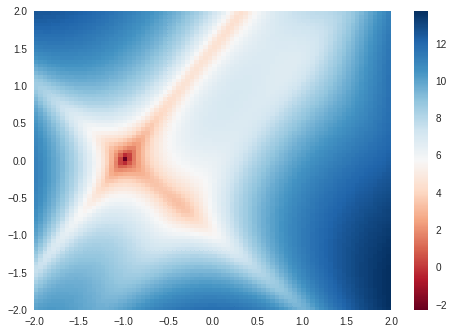

In [5]:
import matplotlib.pyplot as plt

dx, dy = 0.05, 0.05 # step size
x, y = np.mgrid[slice(bounds[0], bounds[1] + dx, dx),
            slice(bounds[0], bounds[1] + dy, dy)]

z = goldstein(x,y)
 
#z = z[:-1,:-1]
plt.pcolormesh(x, y, z, cmap='RdBu')
plt.colorbar()

# Define Instance Space
Let's simply assume that we discretize the y-axis into 20 instances

Text(0.5,0,'$\\theta$')

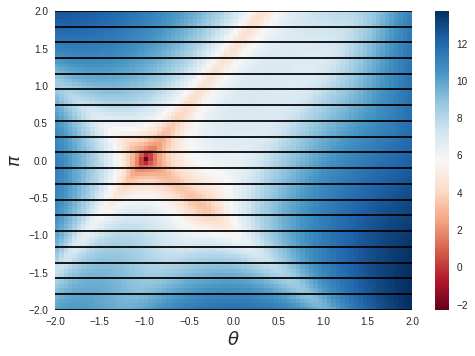

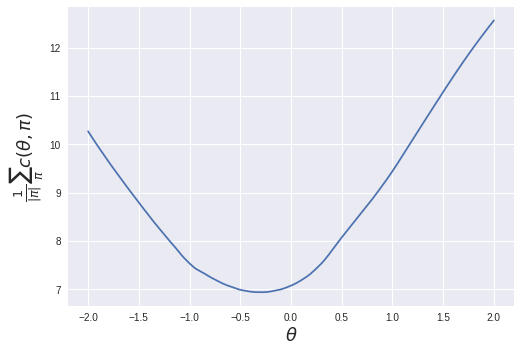

In [6]:
insts = np.linspace(bounds[0], bounds[1], 20)
insts_str = list(map(str, insts)) # we will need them later for SMAC as strings

# plot in 2d
plt.pcolormesh(x, y, z, cmap='RdBu')
plt.colorbar()
for inst in insts:
  plt.plot(bounds, [inst,inst], c='black')
plt.ylabel(r'$\pi$',{'fontsize': 18})
plt.xlabel(r'$\theta$',{'fontsize': 18})
  
#plot in 1d
Y = []
X = np.linspace(bounds[0], bounds[1], 200)
for x_ in X:
  x_ = {"x1": x_}
  # sum over all instances
  y_ = np.mean([goldstein(x_,inst) for inst in insts_str])
  Y.append(y_)   
    
    
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.plot(X,Y)
plt.ylabel(r'$\frac{1}{|\pi|}\sum_{\pi}c(\theta,\pi)$',{'fontsize': 18})
plt.xlabel(r'$\theta$',{'fontsize': 18})

# SMAC with Instances

If we provide SMAC with a set of instances,
it will optimize the target function across this instance sets (using an average).
This can be very useful, if the target function can be written as a sum of its components
and the evaluation of each component is already very expensive.

In the following example, we grant SMAC only 60 function evaluations,
which would correspond to only 3 function evaluations across all 20 instances.
Since it is impossible to optimize the function with 3 function evaluations,
SMAC will use an aggressive racing on the set of instances 
to reject bad configurations quickly.
Therefore, SMAC will consider more than 10 configurations within 60 function evaluations.

Please note that SMAC will print in the end the "estimated cost" of a configuration. This cost estimates is based on the instances SMAC evaluated with the final incumbent.
Depending on the cost distribution over the instances, this cost estimates can misleading and cannot be compared with results of other SMAC runs.

In [7]:
# Configuration Space
from smac.configspace import ConfigurationSpace
from ConfigSpace.hyperparameters import UniformFloatHyperparameter

# Build configuration space

cs = ConfigurationSpace(seed=1234)
x1 = UniformFloatHyperparameter(name="x1", lower=bounds[0], upper=bounds[1], default_value=-1.5)

# add parameters to config space
cs.add_hyperparameters([x1])

# Special EPM Settings
from smac.epm.rf_with_instances import RandomForestWithInstances
types, bounds_rf = np.array([0]), np.array([bounds])
model = RandomForestWithInstances(types=types, 
                                bounds=bounds_rf,
                                seed=12345,
                                ratio_features=1,
                                num_trees=1000,
                                min_samples_split=1,
                                min_samples_leaf=1,
                                max_depth=100000,
                                do_bootstrapping=False,
                                n_points_per_tree=-1,
                                eps_purity=0)  

# SMAC
from smac.scenario.scenario import Scenario
from smac.facade.smac_facade import SMAC

print(insts_str)

# Build a scenario
scenario = Scenario({"run_obj": "quality",  # we optimize quality 
                     "runcount-limit": 60,  # maximum number of function evaluations
                     "cs": cs,               # configuration space
                     "deterministic": "true",
                     "instances": [[inst] for inst in insts_str]
                     })

# start SMAC
smac = SMAC(scenario=scenario, 
            model=model,
            rng=np.random.RandomState(1234),
            tae_runner=goldstein)

best_x = smac.optimize()


INFO:smac.scenario.scenario.Scenario:Output to smac3-output_2018-05-04_07:37:37_394205
INFO:smac.facade.smac_facade.SMAC:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic!


['-2.0', '-1.7894736842105263', '-1.5789473684210527', '-1.368421052631579', '-1.1578947368421053', '-0.9473684210526316', '-0.736842105263158', '-0.5263157894736843', '-0.3157894736842106', '-0.10526315789473695', '0.10526315789473673', '0.3157894736842106', '0.5263157894736841', '0.7368421052631575', '0.9473684210526314', '1.1578947368421053', '1.3684210526315788', '1.5789473684210522', '1.789473684210526', '2.0']


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 3 runs: 8.9955
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 5 runs: 8.2604
INFO:smac.intensification.intensification.Intensifier:Challenger (6.5521) is better than incumbent (8.4148) on 7 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  x1 : -1.5 -> -0.5481544822948852
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 7 runs: 6.5521
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 9 runs: 6.1826
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 11 runs: 6.9982
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 13 runs: 6.6780
INFO:smac.intensification.intensification.Intensifier:Challenger (

# Plot SMAC's runhistory

By plotting all evaluated points (configurations x instances),
we see that SMAC evaluated only promising configurations (more in the middle of the bounds) on many instances,
and all other configurations were evaluated only on few instances.

In [0]:
def get_data():
  '''Helper function to extract evaluated points from runhistory
  
  Returns
  -------
  X_r: np.ndarray[#samples, #configurations x instance feature]
    all evaluated pairs of configurations and instances
  Z_r: np.ndarray[#samples]
    cost of each evaluated sample
  
  '''
  runhistory = smac.get_runhistory()
  X_r, Z_r = [], []
  for run in runhistory.data:
    # configuration
    config_id = run.config_id
    config = runhistory.ids_config[config_id]
    x_1 = config["x1"]
    # instance
    inst = run.instance_id
    x_2 = float(inst) # cheat for fast access to instance features
    X_r.append([x_1,x_2])
    # cost
    entry = runhistory.data[run]
    Z_r.append(entry.cost)
  return np.array(X_r), np.array(Z_r)

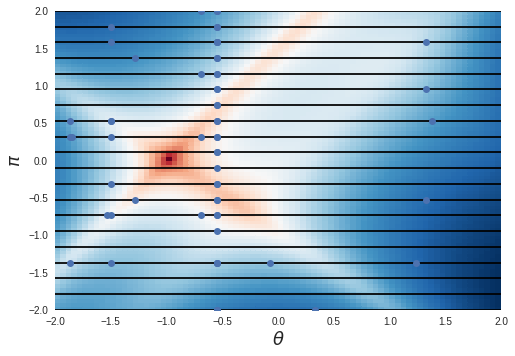

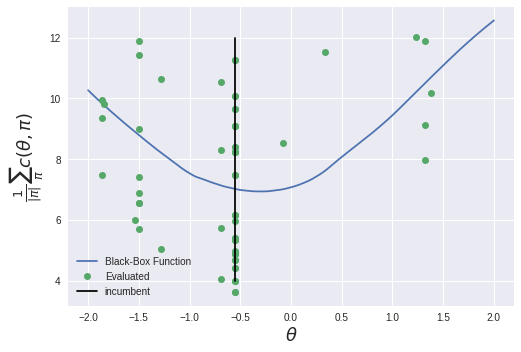

In [9]:
def plot_rh():
  # plot in 2d
  plt.pcolormesh(x, y, z, cmap='RdBu')
  for inst in insts:
    plt.plot(bounds, [inst,inst], c='black')
  plt.ylabel(r'$\pi$',{'fontsize': 18})
  plt.xlabel(r'$\theta$',{'fontsize': 18})
  
  X_r, Z_r = get_data()
  Y_r = X_r[:,1]
  X_r = X_r[:,0]
  # plot evaluated points (in configuration-instance space)
  plt.plot(X_r,Y_r, 'o')
  
  # plot in 1d
  fig1 = plt.figure()
  ax1 = fig1.add_subplot(111)
  # plot function
  ax1.plot(X,Y, label='Black-Box Function')
  # plot evaluated points (in configuration-cost space)
  ax1.plot(X_r,Z_r,'o', label='Evaluated')
  
  ax1.plot([best_x["x1"],best_x["x1"]],[4,12], c="black", label="incumbent")
  ax1.legend()
  plt.ylabel(r'$\frac{1}{|\pi|}\sum_{\pi}c(\theta,\pi)$',{'fontsize': 18})
  plt.xlabel(r'$\theta$',{'fontsize': 18})
  
plot_rh()

# Add Instance Features

Without instance features, the SMAC's internal prediction model (EPM) cannot distinguish between instances.
To help SMAC, you can also provide instance features, i.e., a numerical representation of instance characteristics.

INFO:smac.scenario.scenario.Scenario:Output to smac3-output_2018-05-04_07:37:50_970768
INFO:smac.facade.smac_facade.SMAC:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic!
INFO:smac.intensification.intensification.Intensifier:Challenger (8.0281) is better than incumbent (10.3425) on 2 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  x1 : -1.5 -> 1.2075561791056515
INFO:smac.intensification.intensification.Intensifier:Challenger (7.4218) is better than incumbent (9.2790) on 3 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  x1 : 1.2075561791056515 -> 0.3485483800908047
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 3 runs: 7.4218
INFO:smac.intensification.intensification.Intensifier:Challenger (7.5797) is better th

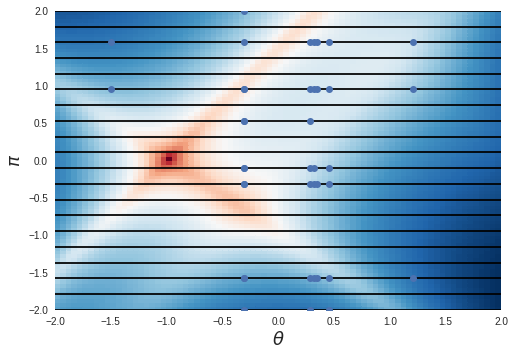

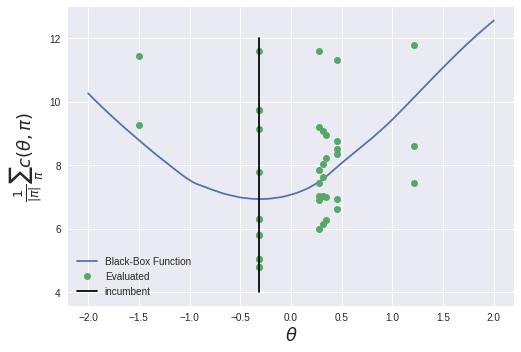

In [10]:
# let's use the coordinates as instance features
feat_dict = {inst: [float(inst)] for inst in insts_str}

# Build an scenario
scenario = Scenario({"run_obj": "quality",  # we optimize quality 
                     "runcount-limit": 40,  # maximum number of function evaluations
                     "cs": cs,               # configuration space
                     "deterministic": "true",
                     "instances": [[inst] for inst in insts_str],
                     "features" : feat_dict
                     })

# start SMAC
smac = SMAC(scenario=scenario, 
            model=model,
            rng=np.random.RandomState(42),
            tae_runner=goldstein)
best_x = smac.optimize()

# plot all evaluated points
plot_rh()

# Better Predictions because of Instance Features?

In the following, let us check whether the instance features help such that we obtain better predictions.
In this example, we simply use the points evaluated in the last SMAC run.

## Without Instance Features

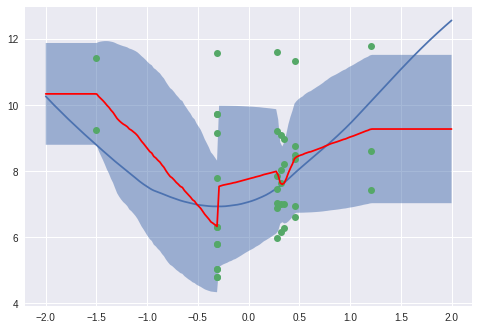

In [11]:
# Construct Random Forest Model
# For illustration, use special hyperparameter settings
# Actually the predictions are better without these settings
types, bounds_rf = np.array([0]), np.array([bounds])
model = RandomForestWithInstances(types=types, 
                                bounds=bounds_rf,
                                seed=12345,
                                ratio_features=1,
                                num_trees=1000,
                                min_samples_split=1,
                                min_samples_leaf=1,
                                max_depth=100000,
                                do_bootstrapping=False,
                                n_points_per_tree=-1,
                                eps_purity=0)  
# get runhistory data
X_r, Z_r = get_data()

# plot in 1d
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
# plot function marginalized across instances
ax1.plot(X,Y) 
# plot points evaluated by SMAC
ax1.plot(X_r[:,0],Z_r,'o') 

# EPM training
Z_r = np.array([[z] for z in Z_r])
X_train = np.array([[x[0]] for x in X_r]) # ignore instance features
model.train(X_train,Z_r) 
# EPM predictions
X_pred = np.array([[x] for x in X])
y_mean, y_var = model.predict_marginalized_over_instances(X_pred)
y_mean = y_mean[:,0]
y_std = np.sqrt(y_var)[:,0]
# Plot predictions
ax1.plot(X,y_mean,c='red')
ax1.fill_between(X, y_mean-y_std, 
                   y_mean+y_std,alpha=0.5)

## With Instance Features


Please note that the EPM learned to intrapolate much better than the EPM without instance features,
although we use a hyperparameter configuration that typically leads to strong over-fitting.

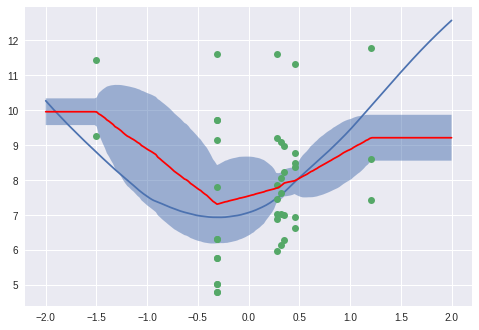

In [12]:
# np.ndarray[instances, features]
features = np.array([f for f in feat_dict.values()])

# Construct Random Forest Model
# For illustration, use special hyperparameter settings
types, bounds_rf = np.array([0,0]), np.array([bounds])
model = RandomForestWithInstances(types=types, 
                                bounds=bounds_rf,
                                instance_features=features,
                                seed=12345,
                                ratio_features=1,
                                num_trees=1000,
                                min_samples_split=1,
                                min_samples_leaf=1,
                                max_depth=100000,
                                do_bootstrapping=False,
                                n_points_per_tree=-1,
                                eps_purity=0)
# get runhistory data
X_r, Z_r = get_data()

# plot in 1d
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.plot(X,Y) # plot function marginalized across instances
ax1.plot(X_r[:,0],Z_r,'o') 

# EPM training
Z_r = np.array([[z] for z in Z_r])
model.train(X_r,Z_r)
# EPM Predictions 
X_pred = np.array([[x] for x in X])
y_mean, y_var = model.predict_marginalized_over_instances(X_pred)
y_mean = y_mean[:,0]
y_std = np.sqrt(y_var)[:,0]
# Plot
ax1.plot(X,y_mean,c='red')
ax1.fill_between(X, y_mean-y_std, 
                   y_mean+y_std,alpha=0.5)